# Mémoire d'alternance - Code

## Import des bibliothèques et récupération des données utilisées

In [1]:
# Bibliothèques standards / exogènes
import pandas as pd, numpy as np, datetime as dt
import matplotlib.pyplot as plt, matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import jarque_bera

# Classes et fonctions créées pour ce mémoire
from écoulement.regression import Regressor
from écoulement.utils import lorenz_curve_and_gini, detect_additive_or_multiplicative, histogram
from impacts_marge.marge_impact import forecast_taux_client, compute_tvmm_dynamic_from_curve, compute_aggregated_tvmm
from impacts_marge.marge_impact import compute_mni_dict, plot_mni_all_models_by_scenario

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
input_path = "écoulement/Data"
data_rate = pd.read_excel(input_path+"/base CSL.xlsx")
concentration_data_base = pd.read_excel(input_path+'/Encours 28022023.xlsx')

Le tableau `data_rate` est composé, pour chaque fin de mois de janvier 2010 à avril 2025 :
- du taux client offert (nommés `Tx_Base` dans le dataframe),
- du taux moyen de rémunération des livrets ordinaires en France (source : Banque de France) (nommés `Tx_BDF` dans le dataframe),
- du taux moyen de rémunération des "super-livrets" des banques en ligne (source : MoneyVox) (nommés `Tx_ligne` dans le dataframe)
- des taux EURIBOR 3M et 12M, extraits sur Bloomberg (nommés `EUR3M` et `EUR12M` dans le dataframe)

In [3]:
data_rate = data_rate.set_index("Date")
# Pour raccourcir les appels futurs, on change les noms des colonnes
name_mapping = {
    "Encours" : "Encours",
    "Tx_Base" : "Taux de base offert",
    "Tx_BDF" : "Taux des livrets ordinaires (Banque de France)",
    "Tx_ligne": "Taux de base moyen des banques en ligne", 
    "EUR12M": "EURIBOR 12M",
    "EUR3M": "EURIBOR 3M",
    "CPI_YoY": "Taux d'inflation français"
}
data_rate.columns = name_mapping.keys()

## 1. Modélisation de l'écoulement - Time-Series model

### 1.1. Sensibilité du taux client au taux de marché

La sensibilité du taux client au taux de marché (l'EURIBOR 3M ici) doit être étudiée car elle correspondra, dans le modèle futur, à une part long terme sensible aux taux. 

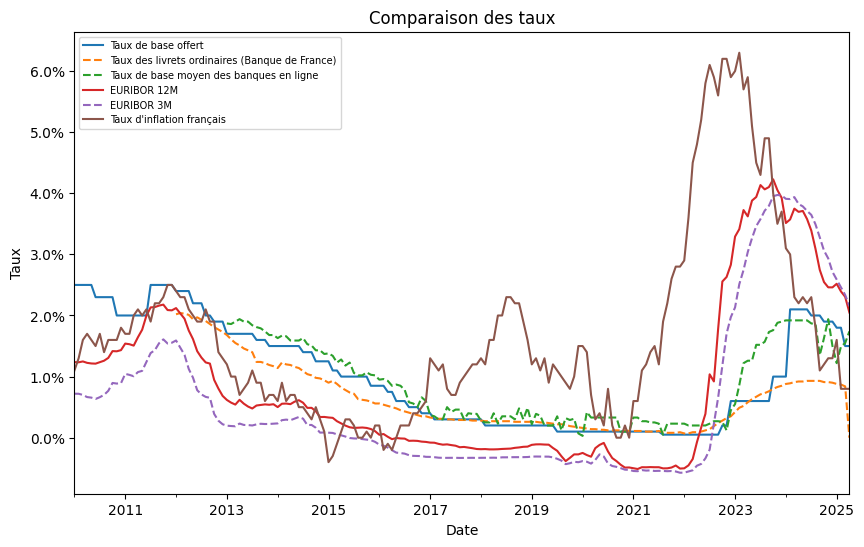

In [4]:
fig, ax = plt.subplots(figsize = (10,6))
for col in data_rate.columns[1:]:
    style = '-' if col in ["Tx_Base", "EUR12M", "CPI_YoY"] else '--'
    data_rate[col].plot(ax=ax, linestyle = style, label = name_mapping[col])

ax.set_xlabel("Date")
ax.set_ylabel("Taux")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax.legend(loc = "upper left", fontsize = 7)
plt.title("Comparaison des taux")
plt.show()

Plusieurs remarques : 
- le taux client offert par l'entité est supérieur aux taux de marché (EURIBORs) et aux taux des livrets ordinaires jusqu'en 2018 (après quoi il devient inférieur aux taux des livrets ordinaires mais reste supérieurs aux taux interbancaires qui entrent en terrain négatif).
- le taux de replacement conventionnel est supérieur jusu'en 2023 au taux de base offert par BforBank : concrètement, cela veut dire que sur cette période, les CSL rapportent plus à BforBank que ce qu'ils ne lui coûtent. 
- dès lors que les taux remontent fortement à partir de juillet 2022, la plupart des relations s'inversent : les taux interbancaires dépassent les taux client, offrant des investissements alternatifs plus attractifs pouvant expliquer les baisses d'encours. De même, les taux proposés par les concurrents directs de BforBank, les banques en ligne, s'écartent à la hausse de ceux de BforBank avant la hausse de fin 2023. Enfin, avec la hausse du taux de base en 2023, le taux de rémunération pour BforBank des CSL devient inférieur à celui offert aux clients, impliquant un coût pour l'entité.


Pour mesurer la sensibilité du taux client au taux de marché, on suppose un modèle linéaire : 
$$TxCli = c + \alpha EUR_{12M} + \varepsilon_t$$

Cela donne les résultats suivants :

In [5]:
client_market_regressor = Regressor(endog=data_rate["Tx_Base"], 
                                    exog=data_rate["EUR12M"],
                                    add_constant=True)
linear_model = client_market_regressor.linear_regression()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Tx_Base   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     70.26
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           1.38e-14
Time:                        15:34:19   Log-Likelihood:                 645.94
No. Observations:                 184   AIC:                            -1288.
Df Residuals:                     182   BIC:                            -1281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0072      0.001     11.231      0.0

On fait des tests de rigueur pour s'assurer qu'il ne s'agit pas d'une régression fallacieuse. En outre, on teste la présence de cointégration à partir de la méthode d'Engle-Granger : 
- si $X \sim I(1)$, $Y \sim I(1)$,
- et les résidus de la régression linéaire sont stationnaires ($I(0)$),
- alors il y a cointégration,
- sinon la régression est fallacieuse. 
Pour vérifier la stationnarité de nos séries, on effectue le test de Dickey-Fuller augmente, qui a pour hypothèse nulle la non stationnarité. On suit une stratégie séquentielle, testant hiérarchiquement les spécifications avec tendance et constante, avec constante uniquement et sans tendance ni constante. 

In [6]:
print("=============== TEST SUR LA SERIE DES TAUX CLIENTS ===============")
Regressor.adf_test(variable=data_rate["Tx_Base"],
                    sequential_strategy = True)
print("=============== TEST SUR LA SERIE DES TAUX EURIBOR 12M ===============")
Regressor.adf_test(variable=data_rate["EUR12M"],
                    sequential_strategy = True)
print("=============== TEST SUR LES RESIDUS DE LA REGRESSION ===============")
long_term_residuals = linear_model.resid 
Regressor.adf_test(variable=long_term_residuals,
                    sequential_strategy = True)

=============== TEST SUR LA SERIE DES TAUX CLIENTS ===============
P-value du test de Dickey-Fuller avec tendance et constante : 0.9919
P-value du test de Dickey-Fuller avec constante : 0.4808
P-value du test de Dickey-Fuller sans tendance ni constante : 0.1855
La série est non stationnaire
=============== TEST SUR LA SERIE DES TAUX EURIBOR 12M ===============
P-value du test de Dickey-Fuller avec tendance et constante : 0.4574
P-value du test de Dickey-Fuller avec constante : 0.2111
P-value du test de Dickey-Fuller sans tendance ni constante : 0.0619
La série est non stationnaire
=============== TEST SUR LES RESIDUS DE LA REGRESSION ===============
P-value du test de Dickey-Fuller avec tendance et constante : 0.1773
P-value du test de Dickey-Fuller avec constante : 0.4230
P-value du test de Dickey-Fuller sans tendance ni constante : 0.0913
La série est non stationnaire


True

Si nos deux séries de taux sont bien intégrées d'ordre 1, les résidus de leur régression ne sont pas stationnaires. Il n'existe donc pas de relation de cointégration. L'EURIBOR 3M étant stationnaire, il n'est pas non plus possible de régresser directement le taux client sur l'EUR3M. Cependant, l'analyse graphique semble indiquer que le taux client répond avec un retard à l'évolution du taux interbancaire. Cela est cohérent économiquement (réponse lagguée des banques au marché), et mérite d'être testée (le bagage théorique sera fourni dans le mémoire associé).

In [7]:
lagged_client_market_regressor = Regressor(endog=data_rate["Tx_Base"].values[1:], 
                                    exog=data_rate["EUR12M"].values[:-1],
                                    add_constant=True)
lagged_linear_model = lagged_client_market_regressor.linear_regression()
print(lagged_linear_model.summary())
print("=============== TEST SUR LA SERIE DES TAUX CLIENTS ===============")
Regressor.adf_test(variable=data_rate["Tx_Base"].values[1:],
                    sequential_strategy = True)
print("=============== TEST SUR LA SERIE DES TAUX EURIBOR 12M ===============")
Regressor.adf_test(variable=data_rate["EUR12M"].values[:-1],
                    sequential_strategy = True)
print("=============== TEST SUR LES RESIDUS DE LA REGRESSION ===============")
lagged_long_term_residuals = lagged_linear_model.resid 
Regressor.adf_test(variable=lagged_long_term_residuals,
                    sequential_strategy = True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     80.72
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           3.38e-16
Time:                        15:34:19   Log-Likelihood:                 647.34
No. Observations:                 183   AIC:                            -1291.
Df Residuals:                     181   BIC:                            -1284.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0070      0.001     11.223      0.0

False

Avec la régression retardée, on obtient des résultats satisfaisants (résidus stationnaires). On procède donc à l'estimation d'un modèle à correction d'erreur "retardé", où la relation de long terme a un lag par rapport à la variable expliquée : 
$$
\Delta TxCli_t = c + \xi \Delta EUR12M_{t-1} + \gamma (\underbrace{TxCli_{t-1} - c - \alpha EUR12M_{t-2}}_{\varepsilon_{t-1}}) + u_t
$$

Cela donne les résultats suivants : 

In [8]:
delta_tx_client = data_rate["Tx_Base"].diff().iloc[1:].values[1:]
delta_EUR12M = data_rate["EUR12M"].diff().iloc[1:].values[:-1]
exog_ecm = pd.DataFrame()
exog_ecm["EUR3M_1"] = delta_EUR12M
exog_ecm["long_term_res_1"] = lagged_long_term_residuals[:-1]
ecm_regressor = Regressor(endog=delta_tx_client, 
        exog=exog_ecm,
        add_constant=True)
ecm_model = ecm_regressor.linear_regression()
print(ecm_model.summary())
Regressor.adf_test(variable=ecm_model.resid,
                    sequential_strategy = True)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     7.688
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           0.000626
Time:                        15:34:19   Log-Likelihood:                 982.07
No. Observations:                 182   AIC:                            -1958.
Df Residuals:                     179   BIC:                            -1949.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.133e-05   8.21e-05     

False

On fait les tests usuels sur les résidus :

============= TEST D'ABSENCE D'AUTOCORRELATION (LJUNG-BOX) =============
P-value du test de Ljung-Box : 0.46060743091187695
Les résidus sont non autocorrélés
=============TEST DE NORMALITE (JARQUE-BERA) =============
P-value du test de Jarque-Bera : 0.0
Statistique du test de Jarque-Bera : 15843.123890722512
Les résidus sont non gaussiens
=============TEST D'HOMOSCEDASTICITE (BREUSCH-PAGAN) =============
LM stat: 9.79712195188986
LM p-value: 0.007457306596946914
F-stat: 5.091914982101341
F-pvalue: 0.007066869575884267


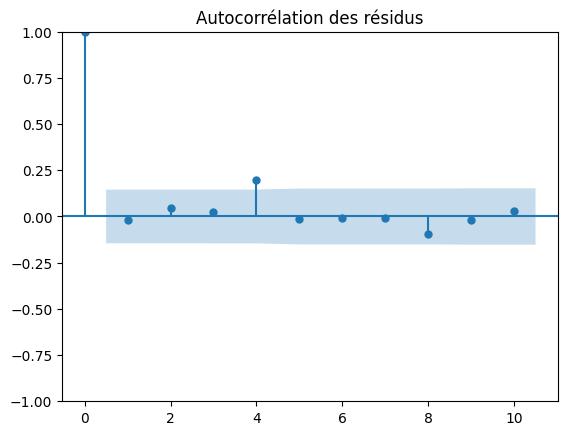

In [9]:
Regressor.checkresiduals(ecm_model)

Le modèle ECM proposé ici est décevant pour plusieurs raisons : 
- le $R^2$ est extrêmement faible (0.079)
- les coefficients sont non significatifs exceptés pour la relation de long terme, et surtout, ils n'ont pas de sens économiquement,
- les résidus présentent de l'hétéroscédasticité.

Nous décidons donc finalement de tester une régression sur les différences premières des séries, afin d'obtenir des séries stationnaires sur lesquelles une régression linéaire est possible. Economiquement, cela fait sens, dans la mesure où cela revient à tester la manière dont le taux offert au client évolue en fonction de l'évolution du taux de marché (c'est une élasticité).

                            OLS Regression Results                            
Dep. Variable:                Tx_Base   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     6.543
Date:                Mon, 16 Jun 2025   Prob (F-statistic):             0.0113
Time:                        15:34:19   Log-Likelihood:                 983.68
No. Observations:                 183   AIC:                            -1963.
Df Residuals:                     181   BIC:                            -1957.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.131e-05   8.33e-05     -0.736      0.4

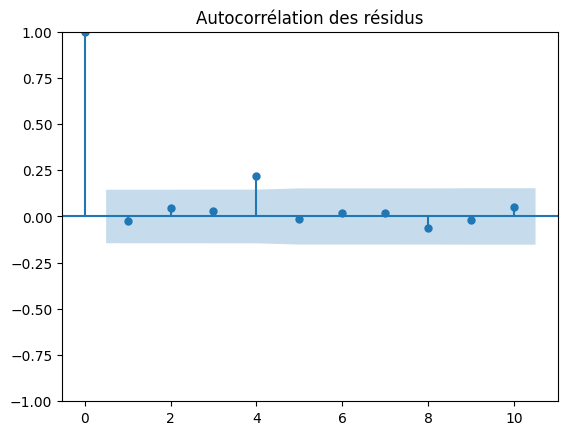

In [10]:
delta_regressor = Regressor(endog=data_rate["Tx_Base"].diff().iloc[1:], 
        exog=data_rate["EUR12M"].diff().iloc[1:],
        add_constant=True)
delta_model = delta_regressor.linear_regression()
print(delta_model.summary())
print("=============== STATIONNARITE DES RESIDUS DE LA REGRESSION ===============")
Regressor.adf_test(variable=delta_model.resid,
                    sequential_strategy = False)
print("=============== CHECK SUR LES RESIDUS ===============")
Regressor.checkresiduals(delta_model)

Ces derniers résultats sont robustes économétriquement, mais le $R^2$ très faible indique un mauvais ajustement du modèle. Il est donc difficile de justifier sa retenue. Notre dernier essai consistera en l'utilisation de variables indicatrices pour prendre en compte les changements de relation apparus après 2022. En effet, le lien entre les deux variables fut modifié par les remontées des taux. Pour le montrer, on calcule à la fois le différentiel de taux, mais aussi la pente de la régression du taux de base sur l'EUR12M avec un historique dont la date de début se décale de mois en mois. 

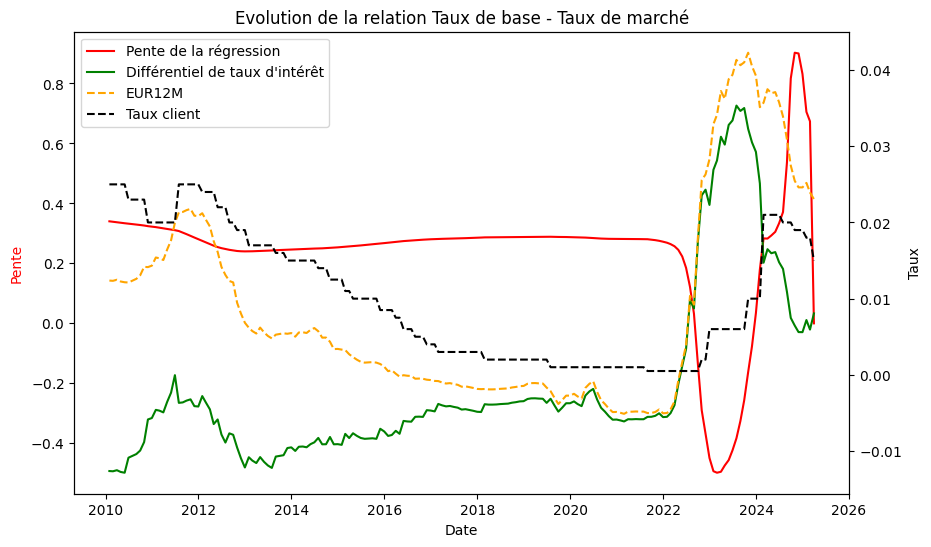

In [11]:
def compute_slope(y,x):
    x_const = sm.add_constant(x)
    return sm.OLS(y, x_const).fit().params[1]

slopes = [] 
for i in range(len(data_rate["Tx_Base"])-1):
        base_window = data_rate["Tx_Base"].iloc[i:]
        EUR12M_window = data_rate["EUR12M"].iloc[i:]
        slopes.append(compute_slope(base_window, EUR12M_window))
slopes = pd.Series(slopes, index = data_rate.index[:-1])
diff = data_rate["EUR12M"] - data_rate["Tx_Base"]
diff = diff[:-1]

fig, ax1 = plt.subplots(figsize=(10,6))
line1, = ax1.plot(data_rate.index[:-1], slopes, color = "red", label = "Pente de la régression")
ax1.set_xlabel('Date')
ax1.set_ylabel("Pente", color = "red")
ax1.yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=True, useMathText = True))

ax2 = ax1.twinx()
line2, = ax2.plot(data_rate.index[:-1], diff, color = "green", label = "Différentiel de taux d'intérêt")
line3, = ax2.plot(data_rate.index[:-1], data_rate["EUR12M"][:-1], color = "orange", linestyle = '--', label = "EUR12M")
line4, = ax2.plot(data_rate.index[:-1], data_rate["Tx_Base"][:-1], color = "black", linestyle = '--', label = "Taux client")
ax2.set_ylabel("Taux", color = "black")
ax2.yaxis.set_major_formatter(mtick.ScalarFormatter(useOffset=True, useMathText=True))

lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc = "upper left")
plt.title("Evolution de la relation Taux de base - Taux de marché")
plt.show()

Outre le début, c'est surtout après 2022 que la relation s'est largement transformée. En effet, l'EURIBOR 12M a augmenté violemment à partir du 7 juillet 2022, avant de se stabiliser à partir de septembre 2023, permettant un rattrapage progressif du taux client. On crée 2 variables indicatrices permettant de prendre en compte ce changement de pente. 

                            OLS Regression Results                            
Dep. Variable:                Tx_Base   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     315.1
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           2.25e-71
Time:                        15:34:20   Log-Likelihood:                 784.54
No. Observations:                 184   AIC:                            -1561.
Df Residuals:                     180   BIC:                            -1548.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0060      0.000     19.354      0.0

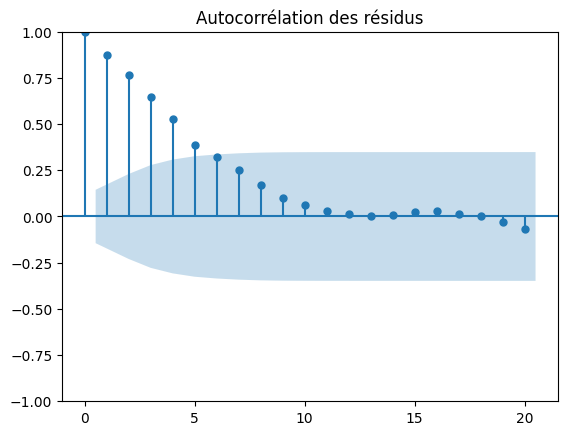

In [12]:
data_rate["X_D1"] =  ((data_rate.index >= '2022-07-01')& (data_rate.index <= '2023-09-01')).astype(int) * data_rate["EUR12M"]
data_rate["X_D2"] =  (data_rate.index > '2023-09-01').astype(int)  * data_rate["EUR12M"]
X = data_rate[["EUR12M", "X_D1", "X_D2"]]
reg = Regressor(endog=data_rate["Tx_Base"], 
        exog=X,
        add_constant=True)
model = reg.linear_regression()
print(model.summary())
print("=============== STATIONNARITE DES RESIDUS DE LA REGRESSION ===============")
Regressor.adf_test(variable=model.resid,
                    sequential_strategy = True)
print("=============== CHECK SUR LES RESIDUS ===============")
Regressor.checkresiduals(model, ljb_lags=[10, 20])

Ce modèle ne permet malheureusement pas de corriger l'autocorrélation des résidus. Finalement, et puisque c'est la pratique, nous allons raisonner sur la période précédent la remontée des taux, et faire l'hypothèse d'une relative continuité. 

In [13]:
data_rate_before_2022 = data_rate[data_rate.index <= dt.datetime(2022,7,1)]
client_market_regressor_before_2022 = Regressor(endog=data_rate_before_2022["Tx_Base"], 
                                    exog=data_rate_before_2022[["EUR12M"]],
                                    add_constant=True)
linear_model_before_2022 = client_market_regressor_before_2022.linear_regression()
print(linear_model_before_2022.summary())

print("=============== TEST SUR LA SERIE DES TAUX CLIENTS ===============")
Regressor.kpss_test(variable=data_rate_before_2022["Tx_Base"],
                    sequential_strategy = False)
print("=============== TEST SUR LA SERIE DES TAUX EURIBOR 12M ===============")
Regressor.kpss_test(variable=data_rate_before_2022["EUR12M"],
                    sequential_strategy = False)
print("=============== TEST SUR LES RESIDUS DE LA REGRESSION ===============")
long_term_residuals_before_2022 = linear_model_before_2022.resid 
Regressor.kpss_test(variable=long_term_residuals_before_2022,
                    sequential_strategy = False)

                            OLS Regression Results                            
Dep. Variable:                Tx_Base   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1128.
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           4.08e-71
Time:                        15:34:20   Log-Likelihood:                 659.78
No. Observations:                 150   AIC:                            -1316.
Df Residuals:                     148   BIC:                            -1310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0059      0.000     21.895      0.0

c:\Users\Giovanni\OneDrive\M2 Quant\S2\Mémoire\Code final réarrangé\écoulement\regression.py:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, pvalue, _, _ = kpss(variable)
c:\Users\Giovanni\OneDrive\M2 Quant\S2\Mémoire\Code final réarrangé\écoulement\regression.py:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, pvalue, _, _ = kpss(variable)


False

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     10.84
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           4.06e-05
Time:                        15:34:20   Log-Likelihood:                 887.45
No. Observations:                 149   AIC:                            -1769.
Df Residuals:                     146   BIC:                            -1760.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0002    5.2e-05     

c:\Users\Giovanni\OneDrive\M2 Quant\S2\Mémoire\Code final réarrangé\écoulement\regression.py:60: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, pvalue, _, _ = kpss(variable)


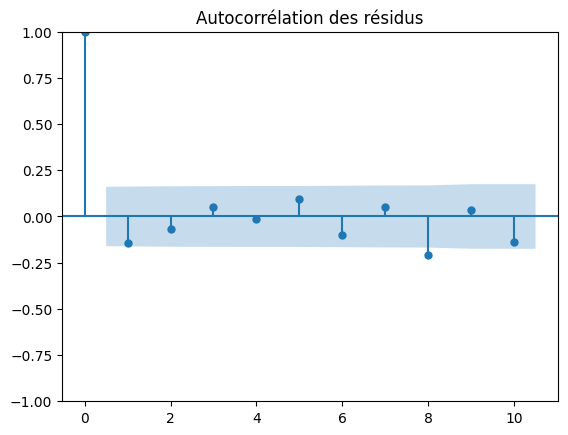

In [14]:
delta_tx_client = data_rate_before_2022["Tx_Base"].diff().iloc[1:].values
delta_EUR12M = data_rate_before_2022["EUR12M"].diff().iloc[1:].values
exog_ecm_before_2022 = pd.DataFrame()
exog_ecm_before_2022["EUR12M_1"] = delta_EUR12M
exog_ecm_before_2022["long_term_res_1"] = long_term_residuals_before_2022.values[:-1]
ecm_regressor_before_2022 = Regressor(endog=delta_tx_client, 
        exog=exog_ecm_before_2022,
        add_constant=True)
ecm_model_before_2022 = ecm_regressor_before_2022.linear_regression()
print(ecm_model_before_2022.summary())
Regressor.kpss_test(variable=ecm_model_before_2022.resid,
                    sequential_strategy = False)
Regressor.checkresiduals(ecm_model_before_2022)

On cherche maintenant le pass-through rate qui minimise la RMSE entre le taux de base et le taux de la relation de long terme.

In [15]:
# Récupération des valeurs
c = linear_model_before_2022.params["const"]
alpha = 1
xi = ecm_model_before_2022.params["EUR12M_1"]
gamma_abs = -ecm_model_before_2022.params["long_term_res_1"]
weighted_PTR = (1-gamma_abs) * xi + gamma_abs * alpha  
weighted_PTR_50 = 0.5 * xi + 0.5 * alpha  

# Calcul des taux à l'aide de relations de long terme
lt = c + alpha * data_rate["EUR12M"]
lt_PTR_weighted = c + weighted_PTR * data_rate["EUR12M"]
lt_PTR_weighted_50 = c + weighted_PTR_50 * data_rate["EUR12M"]
lt_xi = c + xi * data_rate["EUR12M"]

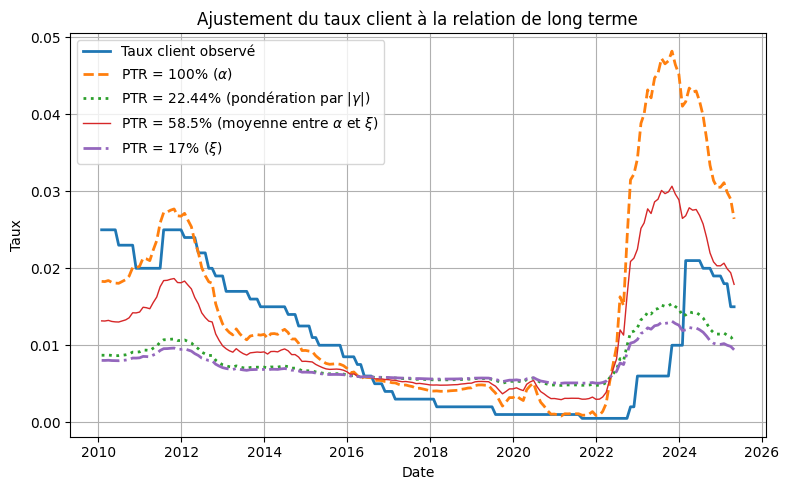

In [16]:
# Représentation graphique
plt.figure(figsize=(8, 5))
plt.plot(data_rate["Tx_Base"], label="Taux client observé", linewidth=2)
plt.plot(lt, label="PTR = 100% ($\\alpha$)", linestyle='--', linewidth=2)
plt.plot(lt_PTR_weighted, label="PTR = 22.44% (pondération par $|\\gamma|$)", linestyle='dotted', linewidth=2)
plt.plot(lt_PTR_weighted_50, label="PTR = 58.5% (moyenne entre $\\alpha$ et $\\xi$)", linestyle='solid', linewidth=1)
plt.plot(lt_xi, label="PTR = 17% ($\\xi$)", linestyle='dashdot', linewidth=2)
plt.title("Ajustement du taux client à la relation de long terme")
plt.xlabel("Date")
plt.ylabel("Taux")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# Calcul des résidus
residus_lt = data_rate["Tx_Base"] - lt
residus_lt_1 =data_rate["Tx_Base"] - lt_PTR_weighted
residus_lt_2 =data_rate["Tx_Base"] - lt_PTR_weighted_50 
residus_lt_3 = data_rate["Tx_Base"] - lt_xi
# Calcul de la RMSE
rmse = lambda x: np.sqrt(np.mean(x**2))
print([rmse(x) for x in [residus_lt, residus_lt_1, residus_lt_2, residus_lt_3]])

[0.012163282956208566, 0.007733072063664905, 0.007965142401077572, 0.008054679541009576]


Conclusion : on retient le modèle avec un PTR égal à la moyenne pondérée par le coefficient d'ajustement des PTR à court et long terme. On identifie un PTR de 22.44%.

In [18]:
PTR = 0.2244

### 1.2. Etude de la concentration

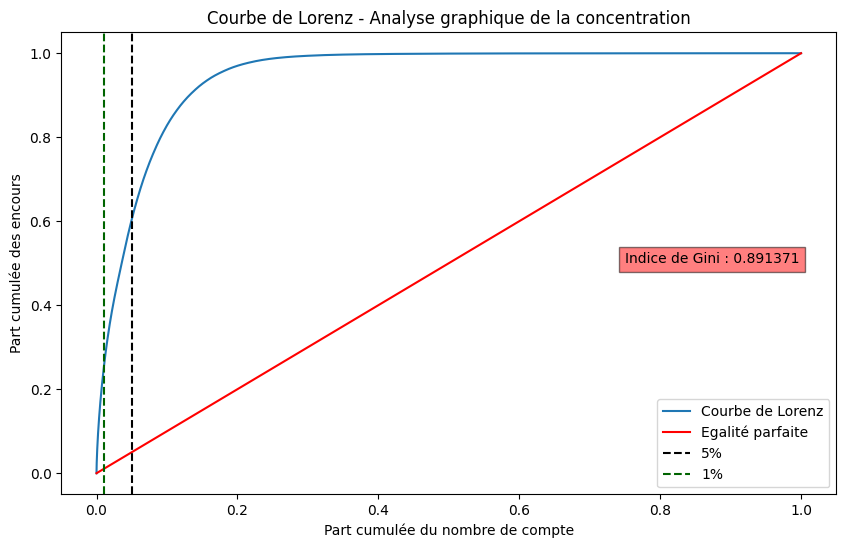

In [19]:
# On supprime les lignes faisant la somme des encours
concentration_data = concentration_data_base.iloc[:-2,:]
outstandings = np.array(concentration_data["Encours total"])
gini = lorenz_curve_and_gini(outstandings)

On consièdre le seuil de concentration comme celui correspondant au 1% des comptes aux montants les plus élevés. Ces comptes représentent 24% de l'encours total.

In [20]:
pc = concentration_data[concentration_data["Encours total"] >= np.quantile(outstandings, 0.99)]["Encours total"].sum()/sum(outstandings)
print(f"Le pourcentage d'encours détenu par le pourcent des plus gros comptes est de : {pc:2f}")
print(f"Cela correspond à un seuil de : {np.quantile(outstandings, 0.99):2f}")

Le pourcentage d'encours détenu par le pourcent des plus gros comptes est de : 0.246146
Cela correspond à un seuil de : 196605.403600


Le seuil de concentration considéré sera ici de 197 000€, et la concentration associée est de 25% (arrondis supérieurs).

In [21]:
CONCENTRATION = 0.25

### 1.3. Estimation de la part stable

La modélisation de série temporelle considérée est la modélisation classique : 
$$
E_t = T_t + S_t + \varepsilon_t \quad \text{Modèle additif}
$$
ou 
$$
E_t = T_t \times S_t \times \varepsilon_t \quad \text{Modèle multiplicatif}
$$
avec $E_t$ les encours en $t$, $T_t$ la tendance, $S_t$ la composante saisonnière et $\varepsilon_t \sim BB(0,\sigma^2)$

On détermine d'abord si la série est multiplicative ou additive. Déjà, notons qu'elle souffre clairement de saisonnalité, comme le montre le graphique des encours et l'autocorrélation de la série stationnarisée : 

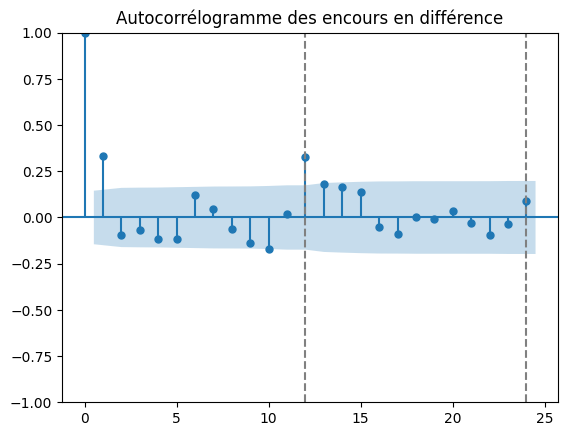

In [22]:
diff_encours = data_rate["Encours"].diff()
plot_acf(diff_encours[1:], lags = 24, title = "Autocorrélogramme des encours en différence")
plt.axvline(x=12, color = "grey", linestyle = "--")
plt.axvline(x=24, color = "grey", linestyle = "--")
plt.show()

On observe assez distinctement un pic d'autocrrélation tous les 12 mois, observation symptômatique d'une saisonnalité annuelle (nos données étant mensuelles). On vérifie la nature de la saisonnalité (additive ou multiplicative) en régressant les écarts-types saisonniers par les moyennes saisonnières.

In [23]:
type_of_series = detect_additive_or_multiplicative(considered_series=data_rate["Encours"], 
                                                   period = 12)
print(f"La série est : {type_of_series}") 

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.248
Date:                Mon, 16 Jun 2025   Prob (F-statistic):             0.0449
Time:                        15:34:21   Log-Likelihood:                -223.14
No. Observations:                  12   AIC:                             450.3
Df Residuals:                      10   BIC:                             451.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.274e+08   3.56e+08     -1.484      0.1

c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


On observe que le coefficient de la régression est statistiquement significatif, ce qui témoigne d'un lien concret entre l'évolution de l'amplitude du cycle saisonnier en fonction du niveau moyen d'encours. La série est multiplicative, et on se ramène à un modèle additive par transformation logarithmique.

In [24]:
log_encours = np.log(data_rate["Encours"])
type_of_series = detect_additive_or_multiplicative(considered_series=log_encours, 
                                                   period = 12)
print(f"La série est : {type_of_series}") 

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.093
Method:                 Least Squares   F-statistic:                   0.06327
Date:                Mon, 16 Jun 2025   Prob (F-statistic):              0.806
Time:                        15:34:21   Log-Likelihood:                 29.997
No. Observations:                  12   AIC:                            -55.99
Df Residuals:                      10   BIC:                            -55.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4731      5.247      0.281      0.7

c:\Users\Giovanni\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


On vérifie que le cycle saisonnier sur la série additive est bien de moyenne nulle :

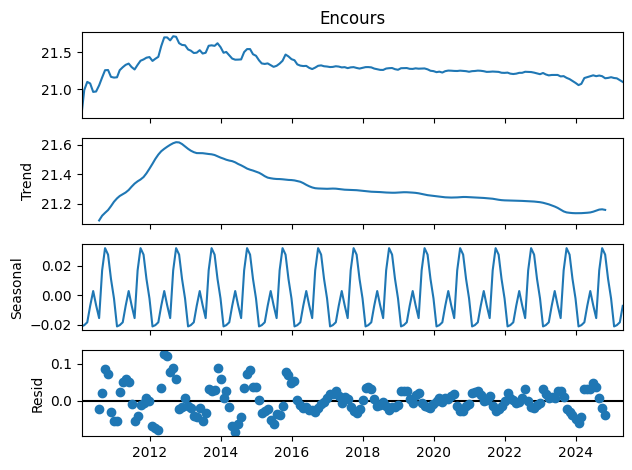

La moyenne du cycle saisonnier est de : -0.000362


In [25]:
result = seasonal_decompose(log_encours, model = "additive", period = 12)
result.plot()
plt.show()
print(f"La moyenne du cycle saisonnier est de : {result.seasonal.mean():2f}")

L'estimation se fait en quatre étapes : 
- estimation de la composante tendancielle
- estimation de la composante saisonnière
- estimation de la composante bruitée et de sa volatilité
- calcul de la part stable comme un pourcentage de la tendance qui soit stable face à la saisonnalité et au bruit

#### 1.3.1. Estimation de la tendance

La tendance s'estime comme une moyenne mobile dont la fenêtre est égale au cycle saisonnier. Ici, on considère donc la moyenne mobile sur 12 mois.

In [26]:
# Estimation de la MM12, suppression des 12 premiers mois
MM12 = log_encours.rolling(window = 12, center = False).mean().dropna() 

#### 1.3.2. Estimation de la saisonnalité

La saisonnalité est estimée comme la moyenne de l'encours hors tendance de chaque mois (la saisonnalité étant annuelle) sur toute la période. Concrètement cela veut dire que la saisonnalité correspond à l'écartement de la tendance (avant traitement du bruit).

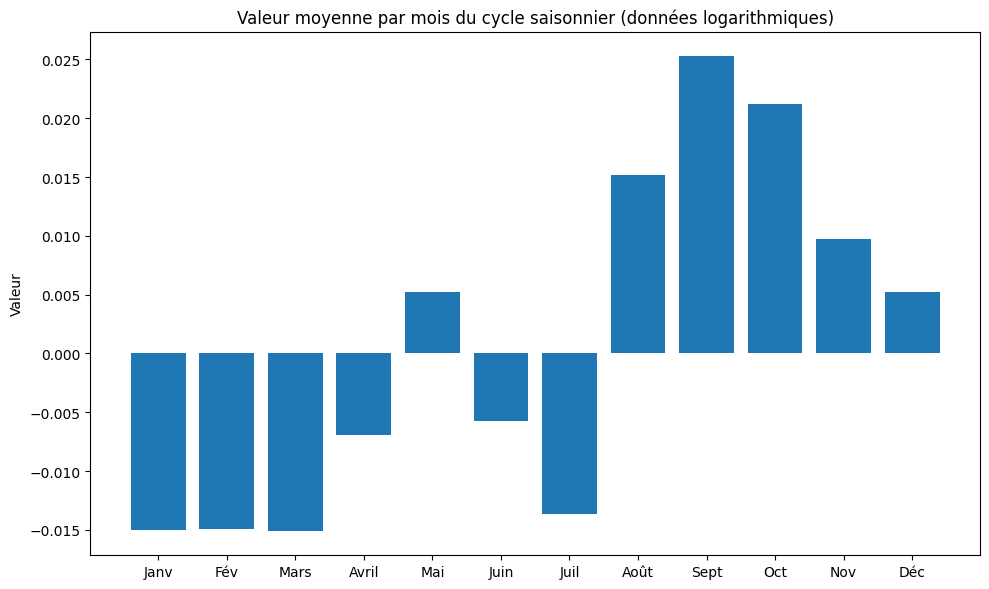

In [27]:
# On a perdu 12 données avec l'utilisation de la moyenne mobile
log_encours_2 = log_encours[log_encours.index >= dt.datetime(2010, 12, 31)]
seasonality = log_encours_2 - MM12

# Moyenne pour chaque mois
seasonality = seasonality.groupby(seasonality.index.month).mean()
centered_seasonality = seasonality - seasonality.mean()
months = ["Janv", "Fév", "Mars", "Avril", "Mai", "Juin", 
          "Juil", "Août", "Sept", "Oct", "Nov", "Déc"]
histogram(months, seasonality, title = "Valeur moyenne par mois du cycle saisonnier (données logarithmiques)")

#### 1.3.3. Estimation du bruit

On traite la saisonnalité à l'aide de la méthode des variables indicatrices. De fait, le bruit s'obtient simplement en inversant la relation de régression temporelle :
$$
\hat{\varepsilon}_i = e_i - (\hat{t_i} + \bar{s}) -  \sum_{j=1}^{12} (s_j - \bar{s}) \mathbf{1}_{i = j}
$$
avec $e, t, s$ les composantes dans le modèle additif (encours, tendance, saisonnalité) après transformation en logarithme, $\bar{s}$ la moyenne des cycles saisonniers et $\mathbf{1}$ l'indicatrice. On procède donc d'abord à la création de 12 variables qui prendront la valeur 1 si le mois en vigueur est celui qui leur est associé et 0 sinon, puis on procède à l'estimation de la composante bruit.

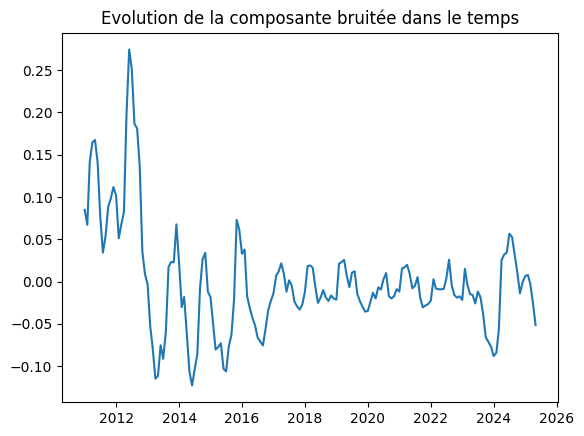

In [28]:
dummies = pd.DataFrame(0, index = log_encours_2.index.values, columns = centered_seasonality.index.values)
for row in dummies.index:
    for col in dummies.columns:
        dummies.loc[row, col] = 1 if row.month == col else 0
bruit = log_encours_2 - (MM12 + seasonality.mean()) - (centered_seasonality * dummies).sum(axis = 1)
plt.plot(bruit)
plt.title("Evolution de la composante bruitée dans le temps")
plt.show()

On vérifie que le bruit est stationnaire. 

In [29]:
Regressor.kpss_test(bruit)

P-value du test KPSS avec tendance et constante : 0.0170
P-value du test KPSS avec constante : 0.0704
La série est stationnaire autour d'une constante


False

Il faut vérifier que le traitement de la saisonnalité réduit bien l'écart-type empirique de la composante bruitée car le traitement a pour objectif de réduire l'estimation de la volatilité des encours.

In [30]:
print(f"L'écart-type du bruit après traitement de la saisonnalité est : {np.std(bruit):2f}")
print(f"L'écart-type du bruit sans traitement de la saisonnalité est : {np.std(log_encours_2 - MM12):2f}")

L'écart-type du bruit après traitement de la saisonnalité est : 0.064088
L'écart-type du bruit sans traitement de la saisonnalité est : 0.065629


Le traitement de la saisonnalité est donc conservé. 

#### 1.3.4. Détermination de la part stable et de sa maturité

On peut donc finalement calculer la part stable comme un pourcentage de la tendance stable face aux effets saisonniers et résiduels. On regarde d'abord si le quantile $Q$ peut être celui de la loi Normale ou non (auquel cas on prendra le centile à 99% empirique) : 

In [31]:
jb_stat_bruit, jb_pval_bruit = jarque_bera(bruit)
print(f"La pvalue du test de Jarque Bera est de : {jb_pval_bruit}")

La pvalue du test de Jarque Bera est de : 2.2532428409826277e-30


La pvalue étant largement inférieure à 5%, on rejette l'hypothèse de normalité. Il vient donc finalement que : 

In [32]:
Q = np.quantile(bruit, 0.99)
stable_part = round((np.exp( (MM12[-1] + seasonality.mean()) + min(centered_seasonality) - Q * np.std(bruit) ))/(
                    np.exp(MM12[-1])),2)
CORRECTED_STABLE_PART = round(stable_part * (1- CONCENTRATION),2)
print(f"Avant correction de la concentration, la part stable est de : {stable_part:2f}")
print(f"Après correction de la concentration, la part stable est de : {CORRECTED_STABLE_PART:2f}")

Avant correction de la concentration, la part stable est de : 0.970000
Après correction de la concentration, la part stable est de : 0.730000


On calibre la maturité de la part stable selon la méthode énoncée dans le mémoire associé : 

In [33]:
diff_MM12 = MM12.diff().dropna()
# Cas 1 : encours en constante progression
if diff_MM12.min() > 0: 
    amortizing_period = len(data_rate["Encours"])

# Cas 2 : le quantile est supérieur à 0 mais pas le min, donc on garde le min 
elif diff_MM12.quantile(0.01) > 0:
    amortizing_period = min(len(data_rate["Encours"]), -1/diff_MM12.min())

# Cas 3 : classique
else : 
    amortizing_period = min(len(data_rate["Encours"]), -1/diff_MM12.quantile(0.01))

# Transformation en annuel
amortizing_period /= 12
print(f"La maturité de la part stable doit être de {round(amortizing_period)} ans")

La maturité de la part stable doit être de 6 ans


### 1.4. Modèle final

Le modèle final d'écoulement en taux qu'on obtient est le suivant : 

In [34]:
summary = pd.DataFrame(columns = ["Nom de la part", "Part de la moyenne mobile", "Maturité"])
summary["Nom de la part"] = ["Part stable 1 (Taux fixe)", "Part stable 2 (Taux variable)", "Part fluctuante", "Part concentrée"]
part_taux_variable = CORRECTED_STABLE_PART * PTR
summary["Part de la moyenne mobile"] = [(CORRECTED_STABLE_PART - part_taux_variable),
                                               part_taux_variable, (1- CORRECTED_STABLE_PART - CONCENTRATION), CONCENTRATION]
summary["Part de la moyenne mobile"] = round(summary["Part de la moyenne mobile"],2)
summary["Maturité"] = ["6 ans", "12 mois", "12 mois", "1 mois"]

display(summary)

,Nom de la part,Part de la moyenne mobile,Maturité
0,Part stable 1 (Taux fixe),0.57,6 ans
1,Part stable 2 (Taux variable),0.16,12 mois
2,Part fluctuante,0.02,12 mois
3,Part concentrée,0.25,1 mois


## 2. Projection des taux d'intérêt

Cette partie a été codée en R, plus adapté à l'exercice. Nous récupérons directement les taux obtenus sous R.

In [35]:
file_path = "impacts_marge"
# On ne considère que les scénarios simulés par TVP-VAR 
all_sheets = {
    name: df.assign(**{col: df[col] / 100 for col in df.columns if col not in ["Date", "Dates"]})
    for name, df in pd.read_excel(file_path + "/Surfaces après choc.xlsx", sheet_name=None).items()
    if "VECM" not in name.upper()
}
print("Feuilles disponibles :", list(all_sheets.keys()))

# Import des courbes avec un grand nombre de dates / maturités ("densifiées")
all_sheets_rate = {}
xls = pd.read_excel(file_path+"/Courbes densifiées NS.xlsx", sheet_name=None)

for name, df in xls.items():
    if "VECM" in name.upper():
        continue  # Ignore les feuilles contenant "VECM" (insensible à la casse)

    df = df.copy()
    for col in df.columns:
        if col != "Date":
            df[col] = df[col] / 100
    all_sheets_rate[name] = df
print("Feuilles disponibles :", list(all_sheets_rate.keys()))

Feuilles disponibles : ['Baseline', 'Up Parallel TVP', 'Down Parallel TVP', 'Up Short TVP', 'Down Short TVP', 'Up Long TVP', 'Down Long TVP']
Feuilles disponibles : ['Baseline', 'Up Parallel TVP', 'Down Parallel TVP', 'Up Short TVP', 'Down Short TVP', 'Up Long TVP', 'Down Long TVP']


## 3. Impact sur la marge des modèles et des taux

On projette le taux client selon le modèle VECM estimé plus haut.

In [36]:
xi = ecm_model_before_2022.params["EUR12M_1"]
gamma = ecm_model_before_2022.params["long_term_res_1"]
c = ecm_model_before_2022.params["const"]
cLT = linear_model_before_2022.params["const"]
alpha = 1
r_client_last = data_rate["Tx_Base"].iloc[-1]
r_ref_last = data_rate["EUR12M"].iloc[-1]
tx_clients_ecm_forecast = {}
for name, df in all_sheets.items():
    eur12m_forecast = df["EUR12M"].values
    forecast_client = forecast_taux_client(
        EUR12M_forecast=eur12m_forecast,
        r_client_last=r_client_last,
        r_ref_last=r_ref_last,
        xi=xi, gamma=gamma, c=c, cLT=cLT, alpha=alpha
    )
    tx_clients_ecm_forecast[name] = forecast_client


On calcule désormais le taux de rémunération de chaque part à encours constants (c'est donc une fonction des taux et de la fréquence de renouvellement) et on calcule le TVMM de l'adossement de chaque modèle considéré.

In [37]:
tvmm_part_taux_fixe = {
    name: compute_tvmm_dynamic_from_curve(df, replacement_ratio=3/72, duration_months=72)
    for name, df in all_sheets_rate.items()
}
tvmm_part_taux_variable = {
    name: compute_tvmm_dynamic_from_curve(df, replacement_ratio=1/12, duration_months=12)
    for name, df in all_sheets_rate.items()
}
tvmm_part_fluctuante = {
    name: compute_tvmm_dynamic_from_curve(df, replacement_ratio=1/12, duration_months=12)
    for name, df in all_sheets_rate.items()
}
tvmm_part_concentree = {
    name: compute_tvmm_dynamic_from_curve(df, replacement_ratio=1/12, duration_months=1)
    for name, df in all_sheets_rate.items()
}
# [% TF, % TV, % PF, % PC]
estimated_model = [0.57, 0.16, 0.02, 0.25]
long_duration_model = [0.8, 0.05, 0.02, 0.13]
short_duration_model = [0.05, 0.5, 0.3, 0.15]
no_rate_sensitivity_model = [0.73, 0, 0.02, 0.25]
fully_sensitive_model = [0, 0.73, 0.02, 0.25]

tvmm_strates = [
    tvmm_part_taux_fixe,      
    tvmm_part_taux_variable,  
    tvmm_part_fluctuante,     
    tvmm_part_concentree      
]

tvmm_estimated     = compute_aggregated_tvmm(tvmm_strates, estimated_model)
tvmm_long_duration = compute_aggregated_tvmm(tvmm_strates, long_duration_model)
tvmm_short_duration= compute_aggregated_tvmm(tvmm_strates, short_duration_model)
tvmm_no_sensitivity= compute_aggregated_tvmm(tvmm_strates, no_rate_sensitivity_model)
tvmm_fully_sens    = compute_aggregated_tvmm(tvmm_strates, fully_sensitive_model)

On peut alors calculer la marge comme la différence entre ce TVMM d'adossement et le taux client offert.

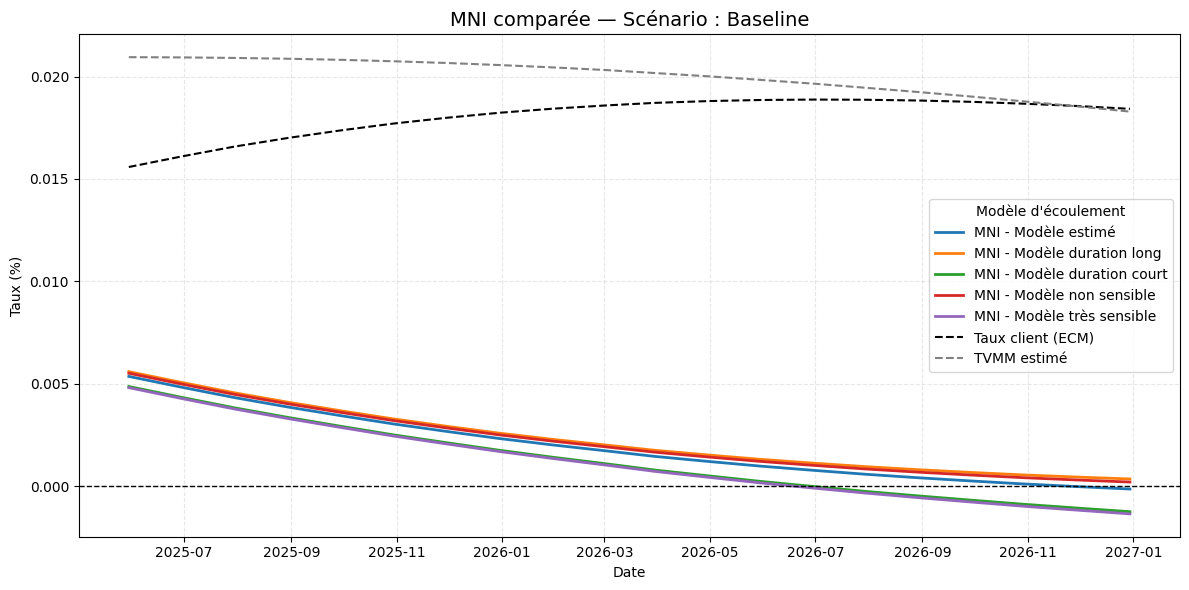

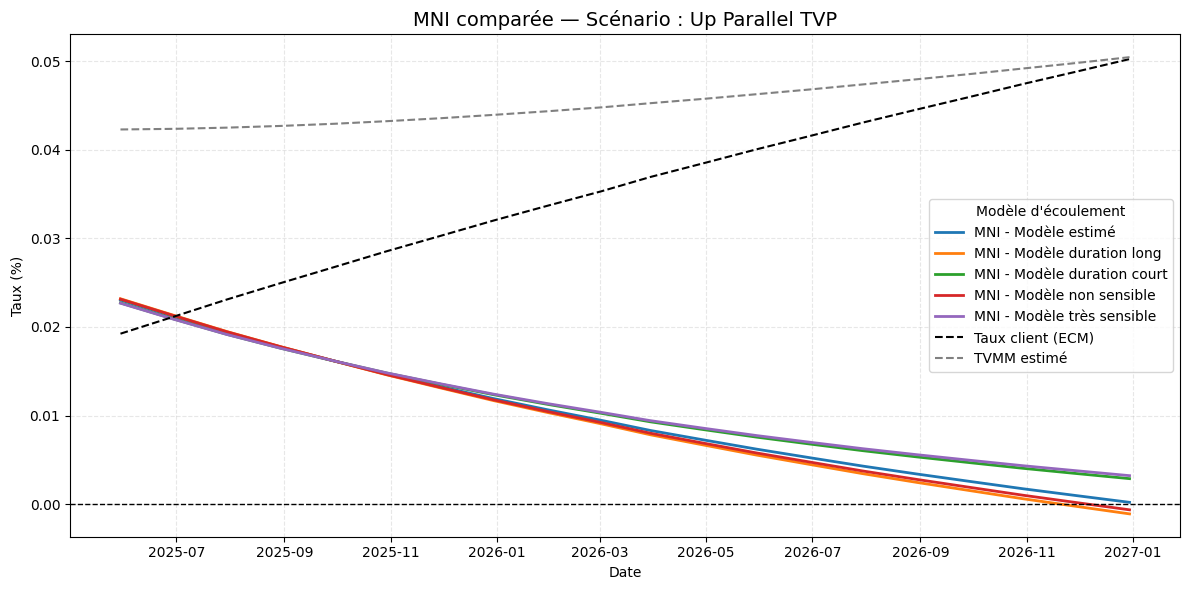

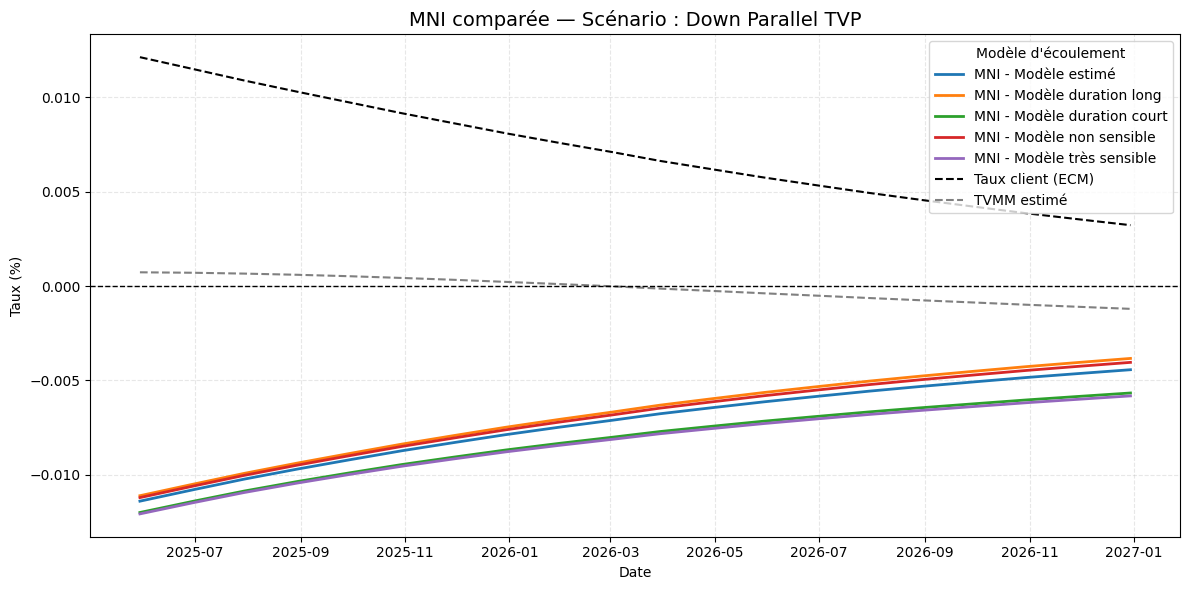

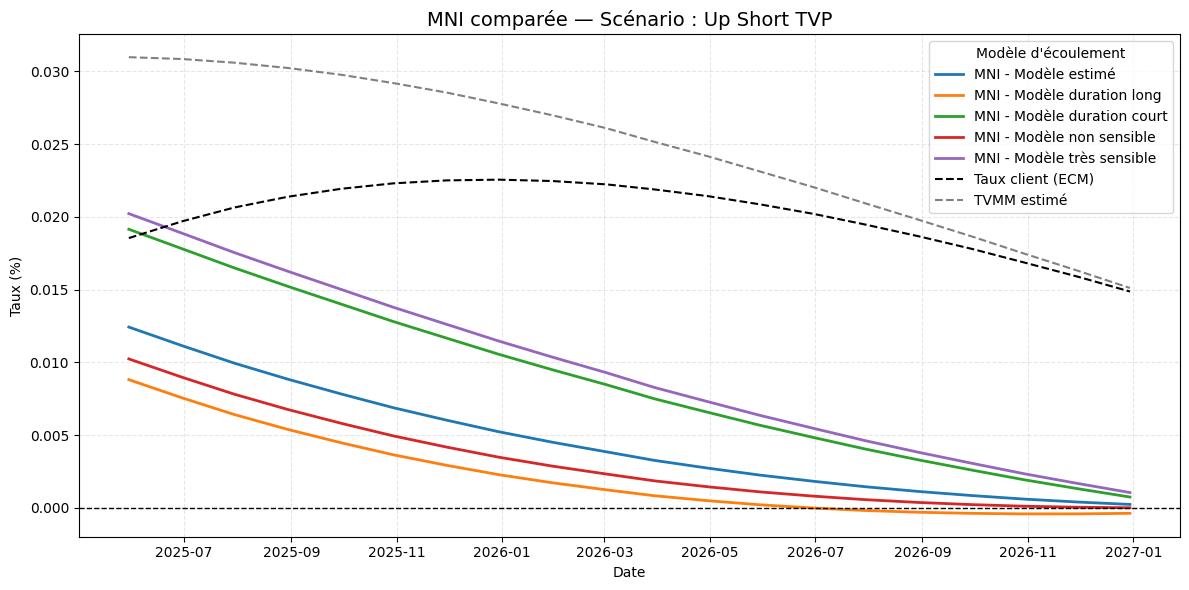

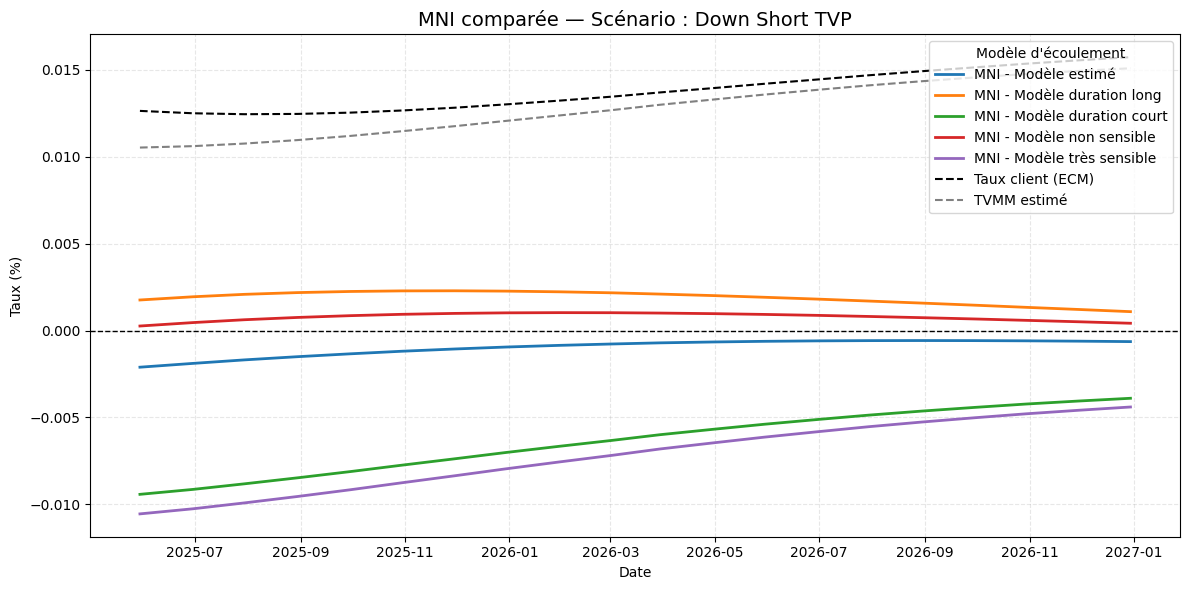

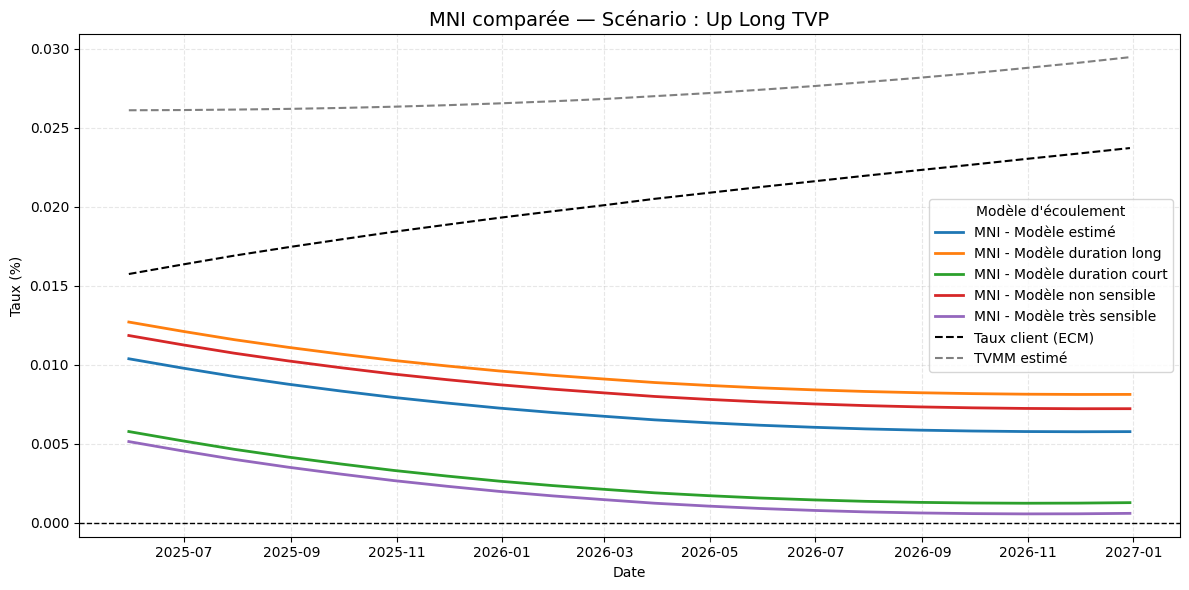

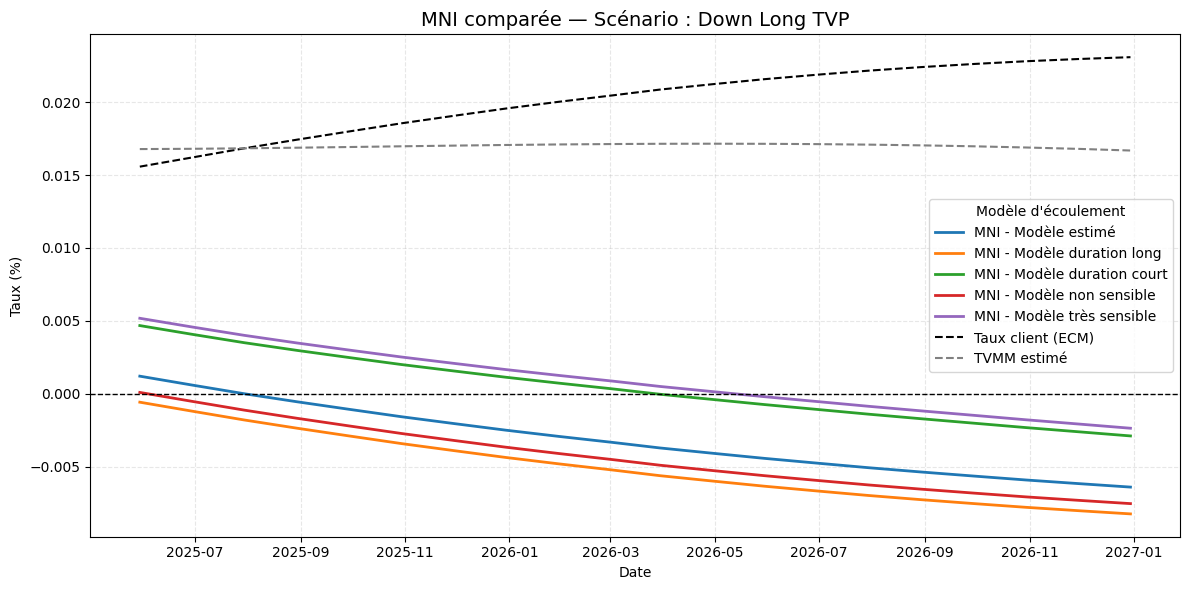

In [38]:
mni_estimated      = compute_mni_dict(tvmm_estimated, tx_clients_ecm_forecast)
mni_long_duration  = compute_mni_dict(tvmm_long_duration, tx_clients_ecm_forecast)
mni_short_duration = compute_mni_dict(tvmm_short_duration, tx_clients_ecm_forecast)
mni_no_sensitivity = compute_mni_dict(tvmm_no_sensitivity, tx_clients_ecm_forecast)
mni_fully_sens     = compute_mni_dict(tvmm_fully_sens, tx_clients_ecm_forecast)

mni_models = {
    "Modèle estimé"        : mni_estimated,
    "Modèle duration long" : mni_long_duration,
    "Modèle duration court": mni_short_duration,
    "Modèle non sensible"  : mni_no_sensitivity,
    "Modèle très sensible" : mni_fully_sens
}

plot_mni_all_models_by_scenario(mni_models, tx_clients_ecm_forecast, tvmm_estimated)


Pour mesurer concrètement les effets du modèle, des taux et de l'interaction entre les deux, nous procédons à une analyse de la variance à deux facteurs avec interaction.

In [39]:
rows = []

for model_name, model_results in mni_models.items():
    for scenario_name, mni_series in model_results.items():
        for date, value in mni_series.items():
            rows.append({
                "MNI": value,
                "Modèle": model_name,
                "Taux": scenario_name
            })
df_anova = pd.DataFrame(rows)
model = ols("MNI ~ C(Modèle) * C(Taux)", data=df_anova).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Pourcentage de variance expliquée
anova_table["% Variance"] = 100 * anova_table["sum_sq"] / anova_table["sum_sq"].sum()

print(anova_table)

                     sum_sq     df           F         PR(>F)  % Variance
C(Modèle)          0.000050    4.0    1.048786   3.811284e-01    0.147169
C(Taux)            0.022212    6.0  309.420459  1.039335e-188   65.128239
C(Modèle):C(Taux)  0.003887   24.0   13.535294   3.111402e-43   11.395883
Residual           0.007956  665.0         NaN            NaN   23.328709


Ce que cela nous dit, concrètement, est que si les modèles en eux-mêmes n'ont pas d'impact réel sur la marge, leur interaction avec les scénarios de taux, elle, explique tout de même plus de 11% de la variance de la marge. 